In [3]:
import os
import sys

cwd = os.getcwd()
sys.path.append(os.path.join(cwd, '..'))

from sklearn.externals import joblib
from aye import *
from aye.preprocessing import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Reader
reader = DataReader(rel_dir='images', ext='jpg')

# Detector
clf = joblib.load('../model/svc.pkl')
scaler = joblib.load('../model/scaler.pkl')
detector = FruitDetector(clf, scaler)

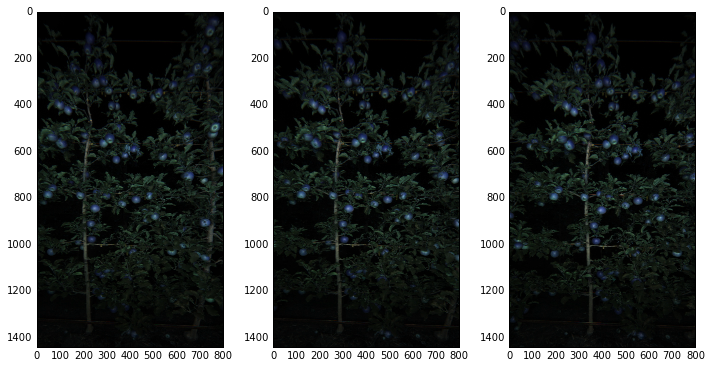

In [8]:
# Load image0 and image1 and image2

images = []
for i in range(3):
    im = reader.read_image(i)
    im = rotate_image(im)
    im = im[:1440, 200:1000, :]
    images.append(im)

fig = plt.figure(figsize=(12, 6))
for i, image in enumerate(images):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.imshow(image)